## Predict TextGrid Events

In [1]:
# KSS Id to run prediction on
kss_id = "1_0007"

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from config import Project
from src.display import Disp
from src.audio import Audio
from src.versioner import FileVersioner
from src.model_wrapper import ModelWrapper

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

In [3]:
available_models = [ 'svr-rbf', 'logr', 'cnn']

fvs = [FileVersioner(Project.path.MODEL, id_, 'wrapper') for id_ in available_models]
paths = [fv.get_saved_path() for fv in fvs]
model_wrappers = [ModelWrapper.load(path) for path in paths]

In [4]:
from src.kss_df import make_kss_df_cls
from src.shared_params import SharedParams


KssDf = make_kss_df_cls(Project.path.TEXTGRID, Project.path.KSSCSV)
kdf_pred = KssDf(kss_id)
shared_params = SharedParams(Project.path.MODEL).load()
audio_params = shared_params['audio']

a_orig = Audio(kdf_pred.audio_path, **audio_params)
X_pred = a_orig.rms.flatten()

print(a_orig.rms.shape)
print(X_pred.shape)

Audio[WARNING]: Modifying input wav from size 154852 to 154880


(1, 2421)
(2421,)


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


## Model Prediction

In [5]:
disp.obj(X_pred.shape, 'X_pred shape')

y_preds = [wrap.predict(X_pred).squeeze() for wrap in model_wrappers]

X_pred shape

(2421,)

ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
ModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)
KerasModelWrapper[INFO]: transformed X, y shapes: (2421, 128), (2421,)


In [6]:
# TODO: Feels like this should belong somewhere (maybe part of model_wrapper?)
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)

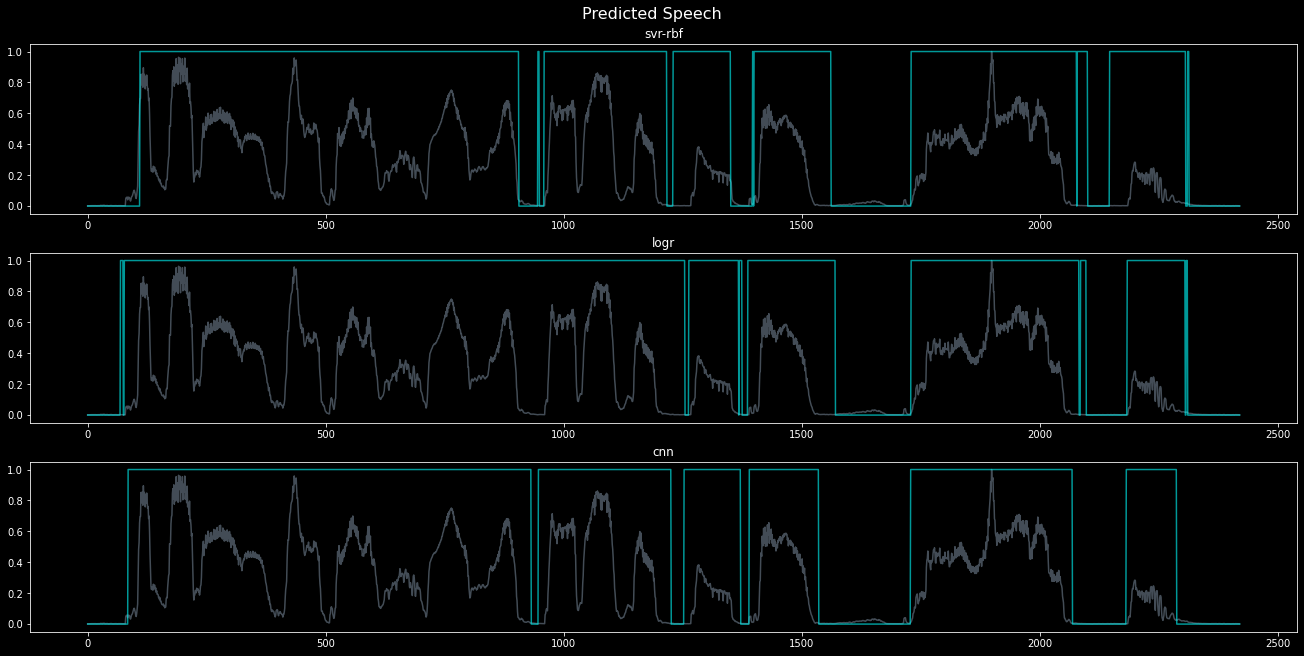

Input Audio

In [7]:
n_plts = len(y_preds)
fig, axs  = plt.subplots(n_plts, 1, figsize=(18,3*n_plts), constrained_layout=True)
fig.suptitle('Predicted Speech', fontsize=16)

for i, model_pred in enumerate(y_preds):
    model_name = model_wrappers[i].id
    axs[i].set_title(f'{model_name}')
    axs[i].plot(X_pred, color='slategray', alpha=0.6, label='X rms waveform')
    axs[i].plot(pred_threshold(model_pred), color='cyan', alpha=0.6, label='speech prediction')

plt.show()

disp.audio(data=a_orig.wav, rate=a_orig.sr, label='Input Audio')

In [8]:
# Choose the best model
model_name = 'cnn'
best_idx = [w.id for w in model_wrappers].index(model_name)
model_wrapper = model_wrappers[best_idx]
y_pred = y_preds[best_idx]
y_pred_bool = pred_threshold(y_pred, 0.5)


ivl idxs

array([  85,  932,  947, 1226, 1253, 1372, 1390, 1536, 1729, 2069, 2182,
       2288])

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True])

Event Indices

array([  85,  932,  947, 1226, 1253, 1372, 1390, 1536, 1729, 2069, 2182,
       2288])

Event Values

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True])

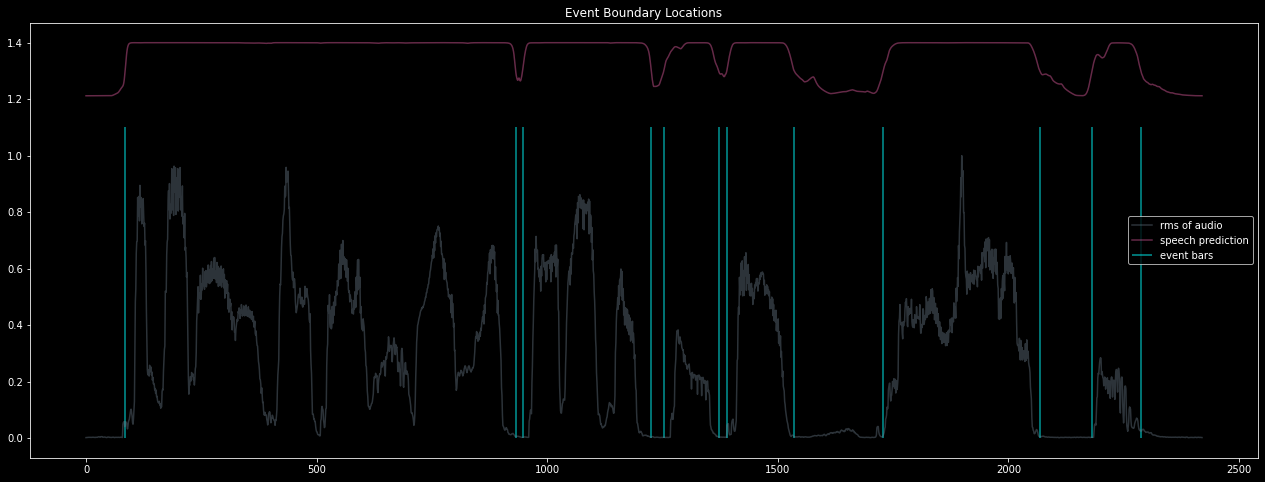

Speech Event_t

array([0.        , 0.12335601, 1.35256236, 1.37433107, 1.77922902,
       1.8184127 , 1.99111111, 2.01723356, 2.22911565, 2.50920635,
       3.00263039, 3.16662132, 3.32045351])

In [26]:
# TODO: Maybe this method belongs somewhere else?
def get_intervals(bs_in):
    # pad the input boolean so that we are guaranteed that the start and end is 0 (False)
    bs = np.pad(bs_in, (1,1), 'edge')
    # diff does bs[i+1] - bs[i], for booleans this means any change in state results in ±1
    d = np.diff(bs)
    # Find the indexes where there is a state change
    # note: np.where returns a tuple matching the dimensions of d (in our case ndim=1).
    ivl_idxs_dim0 = np.where(d > 0)[0]
    disp.obj(ivl_idxs_dim0, 'ivl idxs')
    disp.obj(bs[ivl_idxs_dim0], 'Testing for Vals')
    return ivl_idxs_dim0, bs[ivl_idxs_dim0]

y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool)
disp.obj(y_pred_event_idxs, "Event Indices")
disp.obj(y_pred_event_vals, "Event Values")


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(X_pred, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(0.2*y_pred+1.2, color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_pred_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_pred_event_t = y_pred_event_idxs  * (a_orig.hop_length/a_orig.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_pred_event_t, (1, 0), constant_values=0.0)
disp.obj(speech_event_t, "Speech Event_t")

In [28]:
def get_tg_version(model_wrapper):
    filename, _ = model_wrapper.find_latest_wrapper()
    version = filename.replace('.wrapper', '')
    return version

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

#Prediction into TextGrid
y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool)
tg_pred_path = kdf_pred.tg_pred_path(get_tg_version(model_wrapper))

# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

# TODO: Combine vals into src, for tighter coupling
def make_textgrid(src, vals):
    ivl_template = string.Template(Path(f'{Project.path.TEMPLATE}/interval.template').read_text())
    item_template = string.Template(Path(f'{Project.path.TEMPLATE}/item.template').read_text())
    item_list_template = string.Template(Path(f'{Project.path.TEMPLATE}/itemlist.template').read_text())
    textgrid_template = string.Template(Path(f'{Project.path.TEMPLATE}/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': f'{vals[i]}' if vals is not None else ' '
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, vals, tg_pred_path):
    with open(tg_pred_path, 'w') as f:
        print(f'saving textgrid to {tg_pred_path}')
        f.write(make_textgrid(src, vals))

tg_vals = np.where(y_pred_event_vals, ' ', '0')
textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
print(f'Path: {tg_pred_path}. Check to see if save is commented or not')
print(make_textgrid(textgrid_src, tg_vals))
save_textgrid(textgrid_src, tg_vals, tg_pred_path)

ivl idxs

array([  85,  932,  947, 1226, 1253, 1372, 1390, 1536, 1729, 2069, 2182,
       2288])

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True])

Path: /Users/dev/Projects/korean-ml/data/korean-single-speaker/kss/1/1_0007.pred.cnn.14.TextGrid. Check to see if save is commented or not
File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0.0
xmax = 3.320453514739229
tiers? <exists>
size = 2
item []:
    item [1]:
        class = "IntervalTier"
        name = "char"
        xmin = 0.0
        xmax = 3.320453514739229
        intervals: size = 12
       intervals [1]:
          xmin = 0.0
          xmax = 0.12335600907029479
          text = "0"
       intervals [2]:
          xmin = 0.12335600907029479
          xmax = 1.352562358276644
          text = " "
       intervals [3]:
          xmin = 1.352562358276644
          xmax = 1.3743310657596373
          text = "0"
       intervals [4]:
          xmin = 1.3743310657596373
          xmax = 1.7792290249433107
          text = " "
       intervals [5]:
          xmin = 1.7792290249433107
          xmax = 1.8184126984126985
          text = "0"
       intervals [6]:
         

In [12]:
# # Validation
# import pandas as pd
# from kss_textgrid import KssTextGrid
# # TODO: Compare Predicted vs Actual TextGrid
#
# tg_dir = 'data/korean-single-speaker/kss/1'
# # tg_file = '1_0003.TextGrid'
# # audio_file = '1_0003.wav'
# # tg_path = f'{tg_dir}/{tg_file}'
# # audio_path = f'{tg_dir}/{audio_file}'
# # print(tg_path)
# # tg = textgrid.TextGrid.fromFile(tg_path)
# val_kss_id = '1_0005'
#
# syls_df_pred = KssTextGrid(val_kss_id, tg_dir, path=tg_pred_path).syls_df()
# disp.obj(syls_df_pred[syls_df_pred['syl'] == '0'], f'Predicted Syl DF for {val_kss_id}')
#
# assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')
#
# syls_df_actual = KssTextGrid(val_kss_id, tg_dir).syls_df()
# disp.obj(syls_df_actual[syls_df_actual['syl'] == '0'], f'Actual Syl DF for {val_kss_id}')